## Preprocessing Dyamond

1) We read the data
2) Reshape variables so that they have equal dimensionality
3) Reshape into data samples fit for the NN and convert into a DataFrame
4) Downsample the data: Remove data above 21kms, remove condensate-free clouds, combat class-imbalance
5) Split into input and output
6) Save as npy

Note: We neither scale nor split the data into training/validation/test sets. <br>
The reason is that i) in order to scale we need the entire dataset but this can only be done in conjunction with the dyamond dataset. Also for cross-validation different scalings will be necessary based on different subsets of the data, ii) The split into subsets will be done by the cross-validation procedure or not at all when training the final model.

In [2]:
# Ran with 900GB
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
# import importlib
# importlib.reload(my_classes)

base_path = '/home/b/b309170'
output_path = base_path + '/my_work/icon-ml_data/cloud_cover_parameterization/grid_cell_based_DYAMOND'

# Add path with my_classes to sys.path
sys.path.insert(0, base_path + '/workspace_icon-ml/cloud_cover_parameterization/')

from my_classes import load_data

VERT_LAYERS = 31

## Parameters for the notebook
# ['all', 'discard_spinup']
days = 'discard_spinup'

#Set a numpy seed for the permutation later on!
np.random.seed(10)

## 1) Reading the data
### Input:
- fr_land: Fraction of land
- coriolis: Coriolis parameter
- zg: Geometric height at full levels (3D)
- qv: Specific water vapor content (3D)
- qc: Specific cloud water content (3D)
- qi: Specific cloud ice content (3D)
- temp: Temperature (3D)
- pres: Pressure (3D)
- u: Zonal wind (3D)
- v: Meridional wind (3D)

$10$ input nodes

### Output:
- clc: Cloud Cover

$1$ output nodes

The data above 21km is capped.

In [3]:
order_of_vars_dyamond = ['hus', 'clw', 'cli', 'ta', 'pa', 'ua', 'va', 'zg', 'coriolis', 'fr_land', 'clc', 'cl_area']

In [4]:
# Load dyamond data
data_dict = load_data(source='split_by_var_name', days=days, resolution='R02B05', order_of_vars=order_of_vars_dyamond, 
                      path='~/bd1179_work/DYAMOND/hvcg_data')

hus
clw
cli
ta
pa
ua
va
clc
cl_area


In [5]:
for key in data_dict.keys():
    print(key, data_dict[key].shape)

hus (467, 31, 79342)
clw (467, 31, 79342)
cli (467, 31, 79342)
ta (467, 31, 79342)
pa (467, 31, 79342)
ua (467, 31, 79342)
va (467, 31, 79342)
zg (31, 79342)
coriolis (79342,)
fr_land (79342,)
clc (467, 31, 79342)
cl_area (467, 31, 79342)


In [6]:
(TIME_STEPS, VERT_LAYERS, HORIZ_FIELDS) = data_dict['clc'].shape

In [7]:
try:
    #Reshaping into nd-arrays of equaling shapes (don't reshape in the vertical)
    data_dict['zg'] = np.repeat(np.expand_dims(data_dict['zg'], 0), TIME_STEPS, axis=0)
    data_dict['coriolis'] = np.repeat(np.expand_dims(data_dict['coriolis'], 0), TIME_STEPS, axis=0)
    data_dict['coriolis'] = np.repeat(np.expand_dims(data_dict['coriolis'], 1), VERT_LAYERS, axis=1)
    data_dict['fr_land'] = np.repeat(np.expand_dims(data_dict['fr_land'], 0), TIME_STEPS, axis=0)
    data_dict['fr_land'] = np.repeat(np.expand_dims(data_dict['fr_land'], 1), VERT_LAYERS, axis=1)
except:
    pass

In [8]:
# Remove the first timesteps of the dyamond simulations since the clc values are 0 across the entire earth there 
remove_steps = []
for i in range(data_dict['clc'].shape[0]):
    if np.all(data_dict['clc'][i,4:,:] == 0):
        remove_steps.append(i)
        TIME_STEPS = TIME_STEPS - 1

# Convert the data to float32!
for key in data_dict.keys():
    data_dict[key] = np.float32(np.delete(data_dict[key], remove_steps, axis=0))
    
remove_steps

[]

In [9]:
# Our Neural Network has trained with clc in [0, 100]!
data_dict['clc'] = 100*data_dict['clc']
data_dict['cl_area'] = 100*data_dict['cl_area']
print(np.max(data_dict['clc'][:, 4:, :]))
print(np.max(data_dict['cl_area'][:, 4:, :]))

100.000015
100.0


In [10]:
# Carry along information about the vertical layer of a grid cell. int16 is sufficient for < 1000.
vert_layers = np.int16(np.repeat(np.expand_dims(np.arange(1, VERT_LAYERS+1), 0), TIME_STEPS, axis=0))
vert_layers = np.repeat(np.expand_dims(vert_layers, 2), HORIZ_FIELDS, axis=2)
vert_layers.shape

(467, 31, 79342)

In [11]:
# Reshaping into 1D-arrays and converting dict into a DataFrame-object (the following is based on Aurelien Geron)
# Remove data above 21kms
for key in order_of_vars_dyamond:
    data_dict[key] = np.reshape(data_dict[key][:, 4:, :], -1)

vert_layers = np.reshape(vert_layers[:, 4:, :], -1)

In [12]:
for key in data_dict.keys():
    print(key, data_dict[key].shape)

hus (1000423278,)
clw (1000423278,)
cli (1000423278,)
ta (1000423278,)
pa (1000423278,)
ua (1000423278,)
va (1000423278,)
zg (1000423278,)
coriolis (1000423278,)
fr_land (1000423278,)
clc (1000423278,)
cl_area (1000423278,)


In [13]:
df = pd.DataFrame.from_dict(data_dict)

# Number of samples/rows
len(df)

1000423278

In [14]:
import gc
del data_dict
gc.collect()

1600

**Downsampling the data (minority class: clc = 0)**

In [15]:
# There are no nans left
assert np.all(np.isnan(df) == False) == True

In [16]:
if days == 'all':
    # We ensure that clc != 0 is as large as clc = 0 (which then has 294 Mio samples) and keep the original order intact
    df_noclc = df.loc[df['clc']==0]
    print(len(df_noclc))

    # len(downsample_indices) will be the number of noclc samples that remain
    downsample_ratio = (len(df) - len(df_noclc))/len(df_noclc)
    shuffled_indices = np.random.permutation(df_noclc.index)
    size_noclc = int(len(df_noclc)*downsample_ratio)

    del df_noclc
    gc.collect()

    downsample_indices = shuffled_indices[:size_noclc] 

    # Concatenate df.loc[df[output_var]!=0].index and downsample_indices
    final_indices = np.concatenate((downsample_indices, df.loc[df['clc']!=0].index))

    del shuffled_indices, downsample_indices
    gc.collect()

    # Sort final_indices so that we can more or less recover the timesteps
    final_indices = np.sort(final_indices)
elif days == 'discard_spinup':
    final_indices = np.load('~/my_work/icon-ml_data/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND/indices_to_keep_after_downsampling.npy')

# Label-based (loc) not positional-based
df = df.loc[final_indices]

In [17]:
# Number of samples after downsampling
len(df)

285179494

In [18]:
#Modifies df as well
def split_input_output(dataset):
    output_clc = dataset['clc']
    output_cl_area = dataset['cl_area']
    del dataset['clc']
    del dataset['cl_area']
    return output_clc, output_cl_area

In [19]:
output_clc, output_cl_area = split_input_output(df)

In [20]:
# Save the data
if days == 'all':
    np.save(output_path + '/cloud_cover_input_dyamond.npy', df)
    np.save(output_path + '/cloud_cover_output_dyamond.npy', output_clc)
    np.save(output_path + '/cloud_area_output_dyamond.npy', output_cl_area)
    np.save(output_path + '/samples_vertical_layers_dyamond.npy', vert_layers[df.index])
elif days == 'discard_spinup':
    np.save(output_path + '/cloud_cover_input_dyamond_no_spinup.npy', df)
    np.save(output_path + '/cloud_cover_output_dyamond_no_spinup.npy', output_clc)
    np.save(output_path + '/cloud_area_output_dyamond_no_spinup.npy', output_cl_area)
    np.save(output_path + '/samples_vertical_layers_dyamond_no_spinup.npy', vert_layers[df.index])

Some tests of the cloud area output

Test whether qi from the saved data coincides with the qi here

In [25]:
np.mean(np.array(output_cl_area))

44.76352

In [26]:
np.mean(np.array(output_clc))

33.936203

In [ ]:
np.mean(diff)

**The means of cloud volume and cloud area fraction look good**

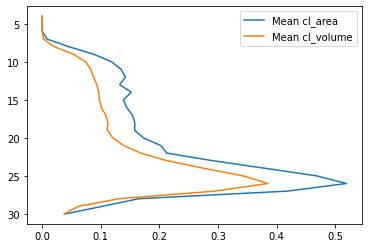

In [17]:
a = np.arange(4, 31)
plt.plot(np.mean(data_dict['cl_area'][:, 4:], axis=(0, 2)), a)
plt.plot(np.mean(data_dict['clc'][:, 4:], axis=(0, 2)), a)
plt.legend(['Mean cl_area', 'Mean cl_volume'])
plt.gca().invert_yaxis()

In [28]:
len(np.where(diff < 0)[0])/len(np.where(diff != 0)[0]) # 1.5% of cloudy data

0.01457981387223618

In [29]:
len(np.where(diff < 0)[0])/len(diff) # 0.9% of the data

0.00902974091038851

In [30]:
diff = np.array(output_cl_area) - np.array(output_clc)

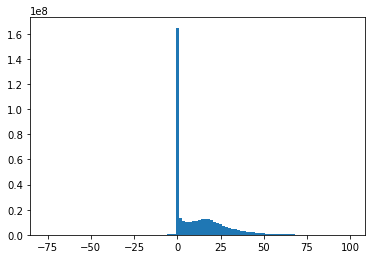

In [31]:
plt.hist(diff, bins = 100)
plt.show()

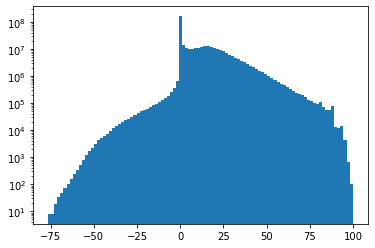

In [32]:
plt.hist(diff, bins = 100, log=True)
plt.show()

In [33]:
# These should be anomalies existing due to differences in coarse-graining
len(np.where(diff < 0)[0])

3421827

In [34]:
len(np.where(diff > 0)[0])

231274379

In [35]:
len(np.where(diff >= 0)[0])

375528913